In [131]:
import json
import pandas as pd
import os
import numpy as np
import glob
import shutil

In [132]:
def add_mean(data, filepath):
    benchmark_score = np.mean(data["test_actual"]) 
    data["avg_benchmark_score"] = benchmark_score
    print(f"MATH mean score: {benchmark_score}")

    with open(filepath, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"🗂 Updated {filepath} data\n")



In [133]:
def load_probe_results(filepath):
    """Load probe predictions and compute detailed metrics if needed."""
    with open(filepath, 'r') as f:
        data = json.load(f)
    return data

In [134]:
# Find all JSON files in the MATH directory
math_dir = "../../probe_results/DATA/SR_DATA/MATH"
json_files = [f for f in glob.glob(f"{math_dir}/**/*.json", recursive=True) if "k_50" in f] #specify k_50 to stop get resutls with rollouts

# Update all JSON files in the current working directory
for file_path in json_files:
    # print(file_path)
    data  = load_probe_results(file_path)
    try:
        print(data["best_layer"])
        add_mean(data, file_path)
    except:
        pass

In [135]:
# Check calibration error

In [136]:
data  = load_probe_results("../probe_results/DATA/SR_DATA/MATH/Qwen-Qwen2.5-Math-7B-Instruct_maxlen_3000_k_50_temp_1.0/best_probe_predictions.json")

In [137]:
data["test_score"]

0.7651610603358513

In [138]:
def compute_ece_binary(probs, labels, n_bins=10):
    """
    Expected Calibration Error (ECE) for binary classification.
    probs: predicted probabilities in [0, 1], shape [N]
    labels: true labels in {0,1} (or [0,1]), shape [N]
    """
    probs = np.asarray(probs).reshape(-1)
    labels = np.asarray(labels).reshape(-1)

    if probs.shape[0] != labels.shape[0]:
        raise ValueError(f"Shape mismatch: probs {probs.shape}, labels {labels.shape}")
    if np.any(probs < 0) or np.any(probs > 1):
        raise ValueError("probs must be in [0,1]. If you have logits, apply sigmoid first.")

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        left, right = bin_edges[i], bin_edges[i + 1]
        # Include right edge only for the last bin
        if i == n_bins - 1:
            bin_mask = (probs >= left) & (probs <= right)
        else:
            bin_mask = (probs >= left) & (probs < right)

        if np.any(bin_mask):
            avg_conf = probs[bin_mask].mean()
            avg_true = labels[bin_mask].mean()  # empirical accuracy for 0/1 labels
            bin_frac = bin_mask.mean()
            ece += np.abs(avg_conf - avg_true) * bin_frac

    return float(ece)

In [139]:
# Example usage:
probs = np.array(data["test_predictions"]) 
labels = np.array(data["test_actual"])
probs_sigmoid = 1 / (1 + np.exp(-probs))  # if not already sigmoid
ece = compute_ece_binary(probs_sigmoid, labels, n_bins=5)
print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.1272


In [140]:
import matplotlib.pyplot as plt
import numpy as np

def reliability_diagram(probs, labels, n_bins=10, title="Reliability diagram", show_hist=True):
    """
    Plots calibration curve (avg confidence vs empirical accuracy per bin).
    """
    probs = np.asarray(probs).reshape(-1)
    labels = np.asarray(labels).reshape(-1)

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    acc = np.full(n_bins, np.nan, dtype=float)
    conf = np.full(n_bins, np.nan, dtype=float)
    counts = np.zeros(n_bins, dtype=int)

    for i in range(n_bins):
        left, right = bin_edges[i], bin_edges[i + 1]
        if i == n_bins - 1:
            mask = (probs >= left) & (probs <= right)
        else:
            mask = (probs >= left) & (probs < right)

        counts[i] = int(mask.sum())
        if counts[i] > 0:
            conf[i] = probs[mask].mean()
            acc[i] = labels[mask].mean()

    if show_hist:
        fig, (ax, ax_hist) = plt.subplots(
            2, 1, figsize=(6, 8), gridspec_kw={"height_ratios": [3, 1]}, sharex=True
        )
    else:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax_hist = None

    # Perfect calibration line
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

    # Only plot bins that have data
    valid = ~np.isnan(acc)
    ax.plot(conf[valid], acc[valid], marker="o")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Empirical accuracy")
    ax.set_title(title)

    if ax_hist is not None:
        ax_hist.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]) * 0.9)
        ax_hist.set_ylabel("Count")
        ax_hist.set_xlabel("Predicted probability bin")

    plt.tight_layout()
    return fig

Expected Calibration Error (ECE): 0.1272


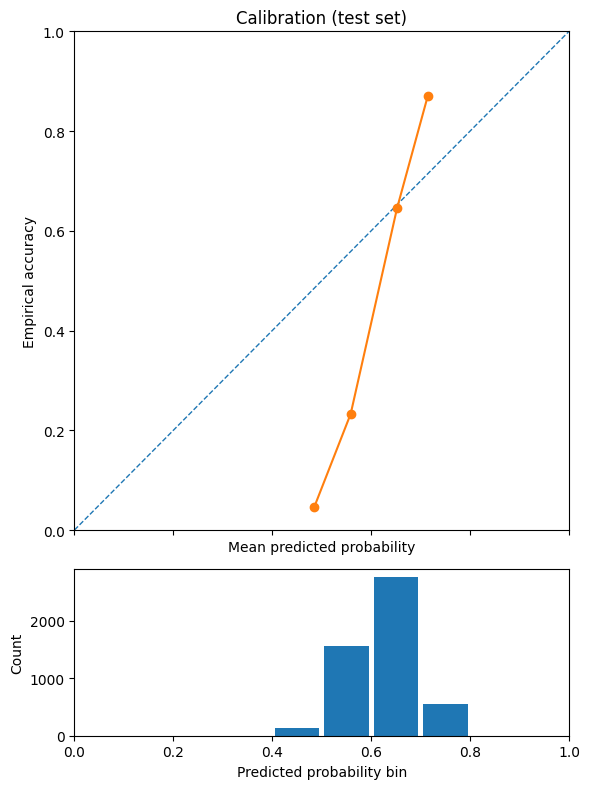

In [141]:
probs = np.array(data["test_predictions"])          # logits or probs
labels = np.array(data["test_actual"])             # 0/1 labels

# If probs are logits:
probs_sigmoid = 1 / (1 + np.exp(-probs))

ece = compute_ece_binary(probs_sigmoid, labels, n_bins=5)
print(f"Expected Calibration Error (ECE): {ece:.4f}")

_ = reliability_diagram(probs_sigmoid, labels, n_bins=10, title="Calibration (test set)", show_hist=True)
plt.show()

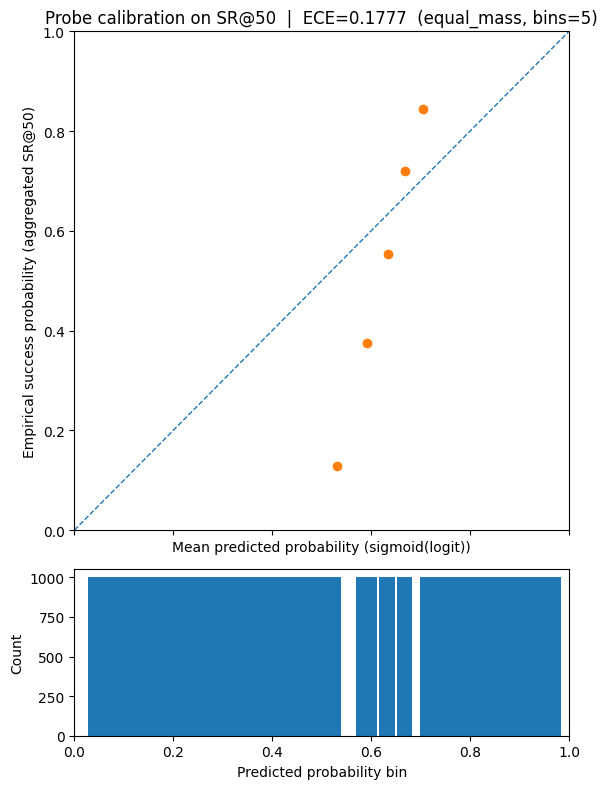

In [142]:
def sigmoid(x):
    x = np.asarray(x)
    return 1.0 / (1.0 + np.exp(-x))

def sr_to_counts(sr, n_trials=50):
    """
    Convert SR@K floats in [0,1] to integer success counts.
    Handles float noise like 0.77999997 by rounding.
    """
    sr = np.asarray(sr).reshape(-1)
    k = np.rint(sr * n_trials).astype(int)
    k = np.clip(k, 0, n_trials)
    n = np.full_like(k, fill_value=n_trials, dtype=int)
    return k, n

def compute_ece_from_counts(probs, success, trials, n_bins=10, strategy="equal_width"):
    """
    ECE comparing predicted probs vs empirical success probability,
    where empirical prob is aggregated from success/trials per bin.

    probs: predicted probabilities in [0,1], shape [N]
    success: integer successes per item, shape [N]
    trials: integer trials per item (here all 50), shape [N]
    """
    probs = np.asarray(probs).reshape(-1)
    success = np.asarray(success).reshape(-1)
    trials = np.asarray(trials).reshape(-1)

    if not (len(probs) == len(success) == len(trials)):
        raise ValueError("probs, success, trials must have same length")
    if np.any(probs < 0) or np.any(probs > 1):
        raise ValueError("probs must be in [0,1]")
    if np.any(success < 0) or np.any(success > trials):
        raise ValueError("success must be in [0,trials]")

    N = len(probs)

    if strategy == "equal_width":
        bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
        bin_ids = np.digitize(probs, bin_edges[1:-1], right=False)  # 0..n_bins-1

    elif strategy == "equal_mass":
        # quantile bins (equal number of points per bin; duplicates handled by unique edges)
        qs = np.linspace(0.0, 1.0, n_bins + 1)
        bin_edges = np.quantile(probs, qs)
        bin_edges[0], bin_edges[-1] = 0.0, 1.0
        # ensure monotone
        bin_edges = np.maximum.accumulate(bin_edges)
        bin_ids = np.digitize(probs, bin_edges[1:-1], right=False)
    else:
        raise ValueError("strategy must be 'equal_width' or 'equal_mass'")

    ece = 0.0
    for b in range(n_bins):
        mask = (bin_ids == b)
        if not np.any(mask):
            continue

        bin_frac = mask.mean()
        avg_conf = probs[mask].mean()

        # aggregate successes/trials -> empirical success prob
        s = success[mask].sum()
        t = trials[mask].sum()
        avg_true = s / t if t > 0 else np.nan

        ece += bin_frac * abs(avg_conf - avg_true)

    return float(ece), bin_edges

def wilson_interval(k, n, z=1.96):
    """
    Wilson score interval for binomial proportion.
    Returns (low, high). Works for aggregated counts too.
    """
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1 + z**2 / n
    center = (phat + z**2 / (2*n)) / denom
    half = (z * np.sqrt((phat*(1-phat) + z**2/(4*n)) / n)) / denom
    return (center - half, center + half)

def reliability_diagram_sr50(
    logits, sr50, n_trials=50, n_bins=10, strategy="equal_mass",
    title="Reliability diagram (SR@50)", show_hist=True
):
    """
    logits: probe logits (x @ activations)
    sr50: SR@50 floats in [0,1]
    """
    probs = sigmoid(logits)
    success, trials = sr_to_counts(sr50, n_trials=n_trials)

    ece, bin_edges = compute_ece_from_counts(
        probs, success, trials, n_bins=n_bins, strategy=strategy
    )

    # assign bins using same edges
    bin_ids = np.digitize(probs, bin_edges[1:-1], right=False)

    mean_pred = np.full(n_bins, np.nan)
    emp = np.full(n_bins, np.nan)
    lo = np.full(n_bins, np.nan)
    hi = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)

    for b in range(n_bins):
        mask = (bin_ids == b)
        counts[b] = int(mask.sum())
        if counts[b] == 0:
            continue
        mean_pred[b] = probs[mask].mean()
        s = success[mask].sum()
        t = trials[mask].sum()
        emp[b] = s / t
        lo[b], hi[b] = wilson_interval(s, t)

    valid = ~np.isnan(emp)

    if show_hist:
        fig, (ax, axh) = plt.subplots(
            2, 1, figsize=(6, 8), gridspec_kw={"height_ratios": [3, 1]}, sharex=True
        )
    else:
        fig, ax = plt.subplots(figsize=(6, 6))
        axh = None

    # perfect calibration
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

    # error bars (Wilson CI)
    yerr = np.vstack([emp[valid] - lo[valid], hi[valid] - emp[valid]])
    ax.errorbar(mean_pred[valid], emp[valid], yerr=yerr, fmt="o", capsize=3)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Mean predicted probability (sigmoid(logit))")
    ax.set_ylabel("Empirical success probability (aggregated SR@50)")
    ax.set_title(f"{title}  |  ECE={ece:.4f}  ({strategy}, bins={n_bins})")

    if axh is not None:
        centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        axh.bar(centers, counts, width=np.diff(bin_edges) * 0.9)
        axh.set_ylabel("Count")
        axh.set_xlabel("Predicted probability bin")

    plt.tight_layout()
    return fig, ece


# ---- usage ----
logits = np.array(data["test_predictions"])   # probe logits
sr50   = np.array(data["test_actual"])        # SR@50 floats

fig, ece = reliability_diagram_sr50(
    logits, sr50, n_trials=50, n_bins=5, strategy="equal_mass",
    title="Probe calibration on SR@50", show_hist=True
)
plt.show()


In [143]:
import numpy as np
import torch
import torch.nn.functional as F

def sr_to_counts(sr, n_trials=50):
    sr = np.asarray(sr).reshape(-1)
    k = np.rint(sr * n_trials).astype(int)
    k = np.clip(k, 0, n_trials)
    n = np.full_like(k, n_trials, dtype=int)
    return k, n

@torch.no_grad()
def apply_temperature(logits, T):
    logits = torch.as_tensor(logits, dtype=torch.float32)
    return logits / float(T)

def fit_temperature_binomial(
    logits_val,
    sr50_val,
    n_trials=50,
    max_iter=200,
    device="cpu",
):
    """
    Fit temperature T>0 by minimizing binomial NLL:
      L = -[k*log(sigmoid(z/T)) + (n-k)*log(1-sigmoid(z/T))] summed over examples
    """
    k_np, n_np = sr_to_counts(sr50_val, n_trials=n_trials)

    z = torch.as_tensor(np.asarray(logits_val).reshape(-1), dtype=torch.float32, device=device)
    k = torch.as_tensor(k_np, dtype=torch.float32, device=device)
    n = torch.as_tensor(n_np, dtype=torch.float32, device=device)

    # parameterize T = exp(log_T) to enforce positivity
    log_T = torch.zeros((), dtype=torch.float32, device=device, requires_grad=True)

    optimizer = torch.optim.LBFGS([log_T], lr=0.5, max_iter=max_iter, line_search_fn="strong_wolfe")

    def closure():
        optimizer.zero_grad()
        T = torch.exp(log_T).clamp(min=1e-6)
        scaled = z / T

        # Binomial NLL per example: -[k*logsigmoid(s) + (n-k)*logsigmoid(-s)]
        loss = -(k * F.logsigmoid(scaled) + (n - k) * F.logsigmoid(-scaled)).mean()
        loss.backward()
        return loss

    optimizer.step(closure)

    T_hat = float(torch.exp(log_T).clamp(min=1e-6).detach().cpu().item())
    return T_hat


In [144]:
def compute_ece_soft(probs, labels, n_bins=10):
    """
    ECE for probabilistic (soft) labels in [0,1].
    probs: predicted probabilities in [0,1], shape [N]
    labels: target probabilities in [0,1], shape [N]
    """
    probs = np.asarray(probs).reshape(-1)
    labels = np.asarray(labels).reshape(-1)

    if probs.shape[0] != labels.shape[0]:
        raise ValueError(f"Shape mismatch: probs {probs.shape}, labels {labels.shape}")
    if np.any(probs < 0) or np.any(probs > 1):
        raise ValueError("probs must be in [0,1]. Apply sigmoid if you have logits.")
    if np.any(labels < 0) or np.any(labels > 1):
        raise ValueError("labels must be in [0,1] for soft-label ECE.")

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        left, right = bin_edges[i], bin_edges[i + 1]
        # include 1.0 in last bin
        if i == n_bins - 1:
            mask = (probs >= left) & (probs <= right)
        else:
            mask = (probs >= left) & (probs < right)

        if np.any(mask):
            avg_conf = probs[mask].mean()
            avg_true = labels[mask].mean()   # mean target probability
            bin_frac = mask.mean()
            ece += np.abs(avg_conf - avg_true) * bin_frac

    return float(ece)


def reliability_diagram_soft(probs, labels, n_bins=10, title="Reliability diagram (soft labels)", show_hist=True):
    """
    Reliability diagram for soft labels:
      x = mean predicted probability per bin
      y = mean target probability per bin
    """
    probs = np.asarray(probs).reshape(-1)
    labels = np.asarray(labels).reshape(-1)

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    mean_pred = np.full(n_bins, np.nan)
    mean_true = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)

    for i in range(n_bins):
        left, right = bin_edges[i], bin_edges[i + 1]
        if i == n_bins - 1:
            mask = (probs >= left) & (probs <= right)
        else:
            mask = (probs >= left) & (probs < right)

        counts[i] = int(mask.sum())
        if counts[i] > 0:
            mean_pred[i] = probs[mask].mean()
            mean_true[i] = labels[mask].mean()

    if show_hist:
        fig, (ax, axh) = plt.subplots(
            2, 1, figsize=(6, 8), gridspec_kw={"height_ratios": [3, 1]}, sharex=True
        )
    else:
        fig, ax = plt.subplots(figsize=(6, 6))
        axh = None

    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    valid = ~np.isnan(mean_true)
    ax.plot(mean_pred[valid], mean_true[valid], marker="o")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Mean target probability")
    ax.set_title(title)

    if axh is not None:
        axh.bar(centers, counts, width=(bin_edges[1] - bin_edges[0]) * 0.9)
        axh.set_ylabel("Count")
        axh.set_xlabel("Predicted probability bin")

    plt.tight_layout()
    return fig

ECE before: 0.12715829934794012
Fitted T: 0.8652506470680237
Test ECE after temp-scaling: 0.1184


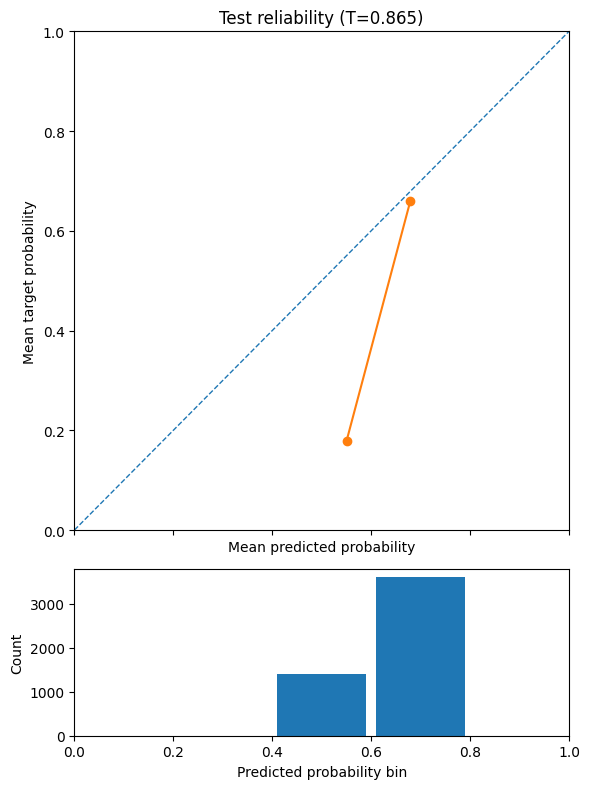

In [145]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def split_calibration(logits_train, sr50_train, cal_frac=0.2, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(logits_train))
    rng.shuffle(idx)
    n_cal = int(round(cal_frac * len(idx)))
    cal_idx = idx[:n_cal]
    rest_idx = idx[n_cal:]
    return (logits_train[cal_idx], sr50_train[cal_idx],
            logits_train[rest_idx], sr50_train[rest_idx])



# --- fit temperature on train-calibration, evaluate on test ---
logits_train = np.asarray(data["train_predictions"])
sr50_train   = np.asarray(data["train_actual"])

logits_test  = np.asarray(data["test_predictions"])
sr50_test    = np.asarray(data["test_actual"])

n_bins=5

logits_cal, sr50_cal, logits_train_rest, sr50_train_rest = split_calibration(
    logits_train, sr50_train, cal_frac=0.2, seed=42
)

ece_before = compute_ece_soft(sigmoid(logits_test), sr50_test, n_bins=n_bins)
print("ECE before:", ece_before)


T = fit_temperature_binomial(logits_cal, sr50_cal, n_trials=50, device="cpu")
print("Fitted T:", T)

# calibrated test probs
probs_test_cal = sigmoid(logits_test / T)

# ECE on test (use your soft-label ECE, or the counts-based one)
ece_test = compute_ece_soft(probs_test_cal, sr50_test, n_bins=n_bins)
print(f"Test ECE after temp-scaling: {ece_test:.4f}")

_ = reliability_diagram_soft(probs_test_cal, sr50_test, n_bins=n_bins,
                             title=f"Test reliability (T={T:.3f})", show_hist=True)
plt.show()

Num bins: 5
Platt params: {'a': 5.705807209014893, 'b': -2.876267433166504}
ECE before: 0.12715829934794012
Test ECE after Platt scaling: 0.0294


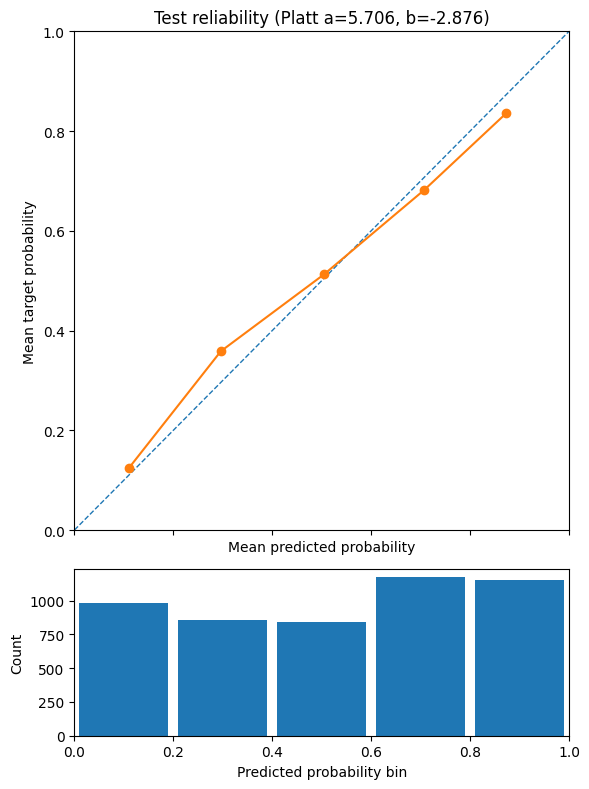

In [146]:
import numpy as np
import torch
import torch.nn.functional as F

def sigmoid_np(x):
    x = np.asarray(x)
    return 1.0 / (1.0 + np.exp(-x))

def sr_to_counts(sr, n_trials=50):
    sr = np.asarray(sr).reshape(-1)
    k = np.rint(sr * n_trials).astype(int)
    k = np.clip(k, 0, n_trials)
    n = np.full_like(k, n_trials, dtype=int)
    return k, n

def fit_platt_binomial(
    logits_cal,
    sr50_cal,
    n_trials=50,
    max_iter=300,
    device="cpu",
):
    """
    Fit Platt scaling parameters (a, b) for:
        p = sigmoid(a * logit + b)
    minimizing binomial NLL using SR@50 -> (k successes out of n trials).
    """
    k_np, n_np = sr_to_counts(sr50_cal, n_trials=n_trials)

    z = torch.as_tensor(np.asarray(logits_cal).reshape(-1), dtype=torch.float32, device=device)
    k = torch.as_tensor(k_np, dtype=torch.float32, device=device)
    n = torch.as_tensor(n_np, dtype=torch.float32, device=device)

    # Initialize: a=1, b=0 (identity-ish)
    a = torch.tensor(1.0, dtype=torch.float32, device=device, requires_grad=True)
    b = torch.tensor(0.0, dtype=torch.float32, device=device, requires_grad=True)

    opt = torch.optim.LBFGS([a, b], lr=0.5, max_iter=max_iter, line_search_fn="strong_wolfe")

    def closure():
        opt.zero_grad()
        s = a * z + b
        # Binomial NLL per example: -[k*logsigmoid(s) + (n-k)*logsigmoid(-s)]
        loss = -(k * F.logsigmoid(s) + (n - k) * F.logsigmoid(-s)).mean()
        loss.backward()
        return loss

    opt.step(closure)

    a_hat = float(a.detach().cpu().item())
    b_hat = float(b.detach().cpu().item())
    return a_hat, b_hat

def apply_platt(logits, a, b):
    logits = np.asarray(logits)
    return sigmoid_np(a * logits + b)


# -------- Usage (calibrate on train-split, evaluate on test) --------
logits_train = np.asarray(data["train_predictions"])
sr50_train   = np.asarray(data["train_actual"])

logits_test  = np.asarray(data["test_predictions"])
sr50_test    = np.asarray(data["test_actual"])

# Option A (recommended): hold out calibration subset from TRAIN
rng = np.random.default_rng(42)
idx = np.arange(len(logits_train))
rng.shuffle(idx)
cal_frac = 0.2
n_cal = int(round(cal_frac * len(idx)))
cal_idx = idx[:n_cal]

logits_cal = logits_train[cal_idx]
sr50_cal   = sr50_train[cal_idx]

n_bins=5
print(f"Num bins: {n_bins}" )

a, b = fit_platt_binomial(logits_cal, sr50_cal, n_trials=50, device="cpu")
print("Platt params:", {"a": a, "b": b})

# Calibrated test probabilities
probs_test_platt = apply_platt(logits_test, a, b)

ece_before = compute_ece_soft(sigmoid(logits_test), sr50_test, n_bins=n_bins)
print("ECE before:", ece_before)

# Example: compute soft-label ECE with your function
ece_after = compute_ece_soft(probs_test_platt, sr50_test, n_bins=n_bins)
print(f"Test ECE after Platt scaling: {ece_after:.4f}")

_ = reliability_diagram_soft(probs_test_platt, sr50_test, n_bins=n_bins,
                             title=f"Test reliability (Platt a={a:.3f}, b={b:.3f})",
                             show_hist=True)
plt.show()


In [147]:
import numpy as np

def sigmoid(x): return 1/(1+np.exp(-x))

def sr_to_counts(sr, n_trials=50):
    k = np.rint(np.asarray(sr)*n_trials).astype(int)
    k = np.clip(k, 0, n_trials)
    n = np.full_like(k, n_trials)
    return k, n

def binomial_nll_from_sr(probs, sr50, n_trials=50, eps=1e-12):
    k, n = sr_to_counts(sr50, n_trials)
    p = np.clip(probs, eps, 1-eps)
    # per-example binomial log-likelihood (up to constant comb term, which cancels in comparisons)
    return float(-np.mean(k*np.log(p) + (n-k)*np.log(1-p)))

def brier(probs, sr50):
    return float(np.mean((np.asarray(probs) - np.asarray(sr50))**2))

# Example:
p0 = sigmoid(logits_test)          # uncalibrated
pT = sigmoid(logits_test / T)      # temperature
pP = 1/(1+np.exp(-(a*logits_test + b)))  # platt

print("NLL  uncal:", binomial_nll_from_sr(p0, sr50_test))
print("NLL  temp :", binomial_nll_from_sr(pT, sr50_test))
print("NLL  platt:", binomial_nll_from_sr(pP, sr50_test))

print("Brier uncal:", brier(p0, sr50_test))
print("Brier temp :", brier(pT, sr50_test))
print("Brier platt:", brier(pP, sr50_test))


NLL  uncal: 32.68859175941529
NLL  temp : 32.73802224080528
NLL  platt: 27.40495822479945
Brier uncal: 0.09582434642447156
Brier temp : 0.0966085918965972
Brier platt: 0.048562637594569476


In [148]:
p0 = sigmoid(logits_test)
pP = sigmoid(a*logits_test + b)

print("Mean SR@50:", float(np.mean(sr50_test)))
print("Mean p (uncal):", float(np.mean(p0)))
print("Mean p (platt):", float(np.mean(pP)))


Mean SR@50: 0.5245039991691709
Mean p (uncal): 0.6251742917808386
Mean p (platt): 0.5241508283134162


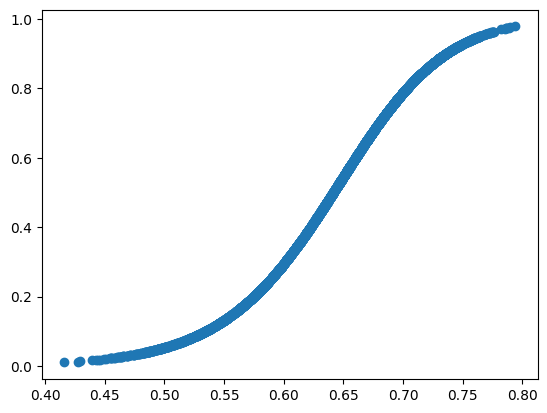

In [149]:
plt.scatter(probs_test_cal, probs_test_platt)

In [150]:
import numpy as np

def sigmoid(x): return 1/(1+np.exp(-x))

def sr_to_counts(sr, n_trials=50):
    k = np.rint(np.asarray(sr)*n_trials).astype(int)
    k = np.clip(k, 0, n_trials)
    n = np.full_like(k, n_trials)
    return k, n

def binom_nll(probs, sr50, n_trials=50, eps=1e-12):
    k, n = sr_to_counts(sr50, n_trials)
    p = np.clip(probs, eps, 1-eps)
    return float(-np.mean(k*np.log(p) + (n-k)*np.log(1-p)))

def audit(name, probs, sr50, n_bins=10):
    probs = np.asarray(probs).reshape(-1)
    sr50  = np.asarray(sr50).reshape(-1)
    assert len(probs) == len(sr50), (len(probs), len(sr50))

    print(f"\n== {name} ==")
    print("N:", len(probs))
    print("mean(y):", float(sr50.mean()))
    print("mean(p):", float(probs.mean()))
    print("NLL:", binom_nll(probs, sr50))

    # equal-mass bins so each bin has signal
    edges = np.quantile(probs, np.linspace(0, 1, n_bins+1))
    edges[0], edges[-1] = 0.0, 1.0
    edges = np.maximum.accumulate(edges)
    bin_id = np.digitize(probs, edges[1:-1], right=False)

    for b in range(n_bins):
        m = bin_id == b
        if not np.any(m): 
            continue
        print(f"bin {b:02d}  count={m.sum():4d}  mean(p)={probs[m].mean():.3f}  mean(y)={sr50[m].mean():.3f}")

n_bins=5
# ---- run on test ----
p_uncal = sigmoid(logits_test)
p_temp  = sigmoid(logits_test / T)
p_platt = sigmoid(a*logits_test + b)

audit("uncal", p_uncal, sr50_test, n_bins=n_bins)
audit("temp",  p_temp,  sr50_test, n_bins=n_bins)
audit("platt", p_platt, sr50_test, n_bins=n_bins)



== uncal ==
N: 5000
mean(y): 0.5245039991691709
mean(p): 0.6251742917808386
NLL: 32.68859175941529
bin 00  count=1000  mean(p)=0.530  mean(y)=0.129
bin 01  count=1000  mean(p)=0.591  mean(y)=0.375
bin 02  count=1000  mean(p)=0.633  mean(y)=0.554
bin 03  count=1000  mean(p)=0.667  mean(y)=0.720
bin 04  count=1000  mean(p)=0.704  mean(y)=0.844

== temp ==
N: 5000
mean(y): 0.5245039991691709
mean(p): 0.6429293219227902
NLL: 32.73802224080528
bin 00  count=1000  mean(p)=0.535  mean(y)=0.129
bin 01  count=1000  mean(p)=0.605  mean(y)=0.375
bin 02  count=1000  mean(p)=0.653  mean(y)=0.554
bin 03  count=1000  mean(p)=0.691  mean(y)=0.720
bin 04  count=1000  mean(p)=0.731  mean(y)=0.844

== platt ==
N: 5000
mean(y): 0.5245039991691709
mean(p): 0.5241508283134162
NLL: 27.40495822479945
bin 00  count=1000  mean(p)=0.113  mean(y)=0.129
bin 01  count=1000  mean(p)=0.319  mean(y)=0.375
bin 02  count=1000  mean(p)=0.559  mean(y)=0.554
bin 03  count=1000  mean(p)=0.748  mean(y)=0.720
bin 04  count=1

In [151]:
logits_test

array([0.82244718, 0.90182704, 0.63486308, ..., 0.72952187, 0.47063488,
       0.13554101])

In [152]:
p_platt

array([0.86014053, 0.90630948, 0.6783368 , ..., 0.78351072, 0.45241556,
       0.10881561])

In [157]:
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, roc_auc_score

In [158]:
spearman_corr, _ = spearmanr(sr50_test, logits_test)
print("Spearman correlation between actual sr and initial predicted sr:", spearman_corr)

spearman_corr, _ = spearmanr(sr50_test, p_temp)
print("Spearman correlation between actual sr and temp scale predicted sr:", spearman_corr)

spearman_corr, _ = spearmanr(sr50_test, p_platt)
print("Spearman correlation between actual sr and plat scale predicted sr:", spearman_corr)

Spearman correlation between actual sr and initial predicted sr: 0.7651610603358513
Spearman correlation between actual sr and temp scale predicted sr: 0.7651610603358513
Spearman correlation between actual sr and plat scale predicted sr: 0.7651610603358513
